In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

### Create a transform for images to ensure that all images are normalized and have the same size

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### Download dataset and split into train, validation and test

In [9]:
trainset = datasets.MNIST('/dataset/train', download = True, train = True, transform = transform)
valset = datasets.MNIST('/dataset/validation', download = True, train = False, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
valloader = torch.utils.data.DataLoader(valset, batch_size = 64, shuffle = True)

dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


### Display the first 16 images from training dataset

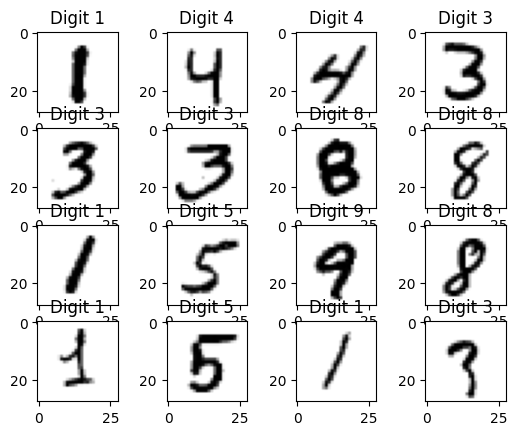

In [13]:
nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)

idx = 0
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].imshow(images[idx].numpy().squeeze(), cmap='gray_r')
        axes[i, j].set_title(f'Digit {labels[idx]}')
        idx += 1

plt.show()

### Build NN

In [14]:
input_size = 784 # 28*28
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim = 1)
)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [16]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels) # NLL loss

In [17]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0029, -0.0029, -0.0029,  ..., -0.0029, -0.0029, -0.0029],
        [-0.0012, -0.0012, -0.0012,  ..., -0.0012, -0.0012, -0.0012],
        [-0.0021, -0.0021, -0.0021,  ..., -0.0021, -0.0021, -0.0021],
        ...,
        [-0.0014, -0.0014, -0.0014,  ..., -0.0014, -0.0014, -0.0014],
        [-0.0018, -0.0018, -0.0018,  ..., -0.0018, -0.0018, -0.0018],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005]])


In [18]:
optimizer = optim.SGD(model.parameters(), lr = 0.003, momentum = 0.9)
time0 = time()
epochs = 15

for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatter images
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        # Calculate loss
        output = model(images)
        loss = criterion(output, labels)

        # Backward pass
        loss.backward()

        # Advance one step
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(epoch, running_loss / len(trainloader)))

print("\nTraining time (in minutes) = ", (time() - time0) / 60)


Epoch 0 - Training loss: 0.6467470151624446
Epoch 1 - Training loss: 0.2818929429199777
Epoch 2 - Training loss: 0.21992022515550605
Epoch 3 - Training loss: 0.17463222025299885
Epoch 4 - Training loss: 0.144334513985955
Epoch 5 - Training loss: 0.12249967968389233
Epoch 6 - Training loss: 0.10809888918874169
Epoch 7 - Training loss: 0.0958066452562666
Epoch 8 - Training loss: 0.08639256600568544
Epoch 9 - Training loss: 0.07774229177823866
Epoch 10 - Training loss: 0.07069656533846405
Epoch 11 - Training loss: 0.06412432900965531
Epoch 12 - Training loss: 0.05788385654925736
Epoch 13 - Training loss: 0.05349794979681815
Epoch 14 - Training loss: 0.049615942798098174

Training time (in minutes) =  1.964759612083435


### Predict one image

Predicted Digit =  2


Text(0.5, 1.0, 'Predicted digits = 2')

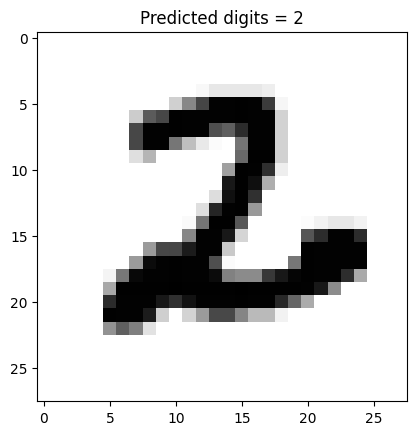

In [28]:
images, labels = next(iter(valloader))

img = images[0].view(1,784)

with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit = ", probab.index(max(probab)))

plt.figure()
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
plt.title(f"Predicted digits = {probab.index(max(probab))}")

### Compute Accuracy

In [29]:
correct_count, all_count = 0, 0
for images, labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)
        
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if true_label == pred_label:
            correct_count += 1
        
        all_count += 1

print(f"Accuracy: {(correct_count / all_count):.4f} %")

Accuracy: 0.9749 %
